Loading Models...


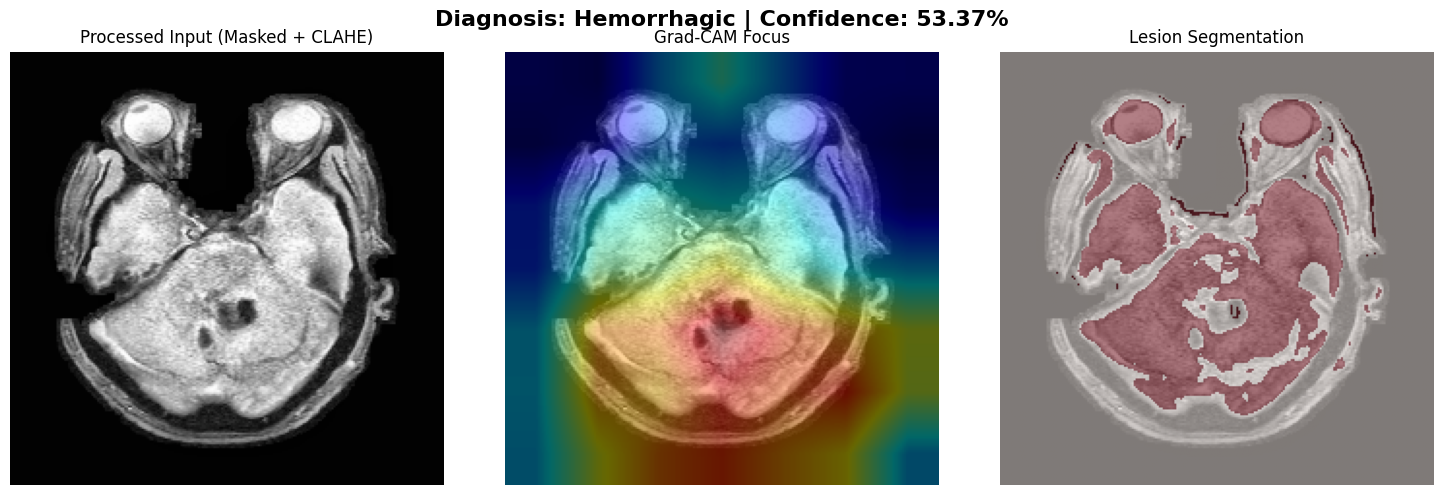

Done. Diagnosis: Hemorrhagic


In [9]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models, transforms
import os

# --- 1. CONFIGURATION ---
CLASSES = ["Hemorrhagic", "Ischemic", "Tumor"]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. YOUR EXACT PREPROCESSING FUNCTIONS ---

# --- 2. PREPROCESSING FUNCTIONS ---
def extract_roi_and_mask(image):
    """
    Robust ROI extraction for MRI:
    1. Blurs and Thresholds to find brain structure.
    2. Dilates to connect fragmented parts (like cerebellum).
    3. Crops the largest contour with padding.
    """
    img_copy = image.copy()
    gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    
    # 1. Blur to remove fine noise (text)
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    
    # 2. Otsu Thresholding
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 3. Dilate to connect brain parts (Fixes the "fragmented brain" issue)
    kernel = np.ones((5,5), np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations=3)
    
    # 4. Find Contours
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return image # Fallback

    # Find largest contour (The Brain)
    c = max(contours, key=cv2.contourArea)
    
    # Area Check: Ignore if the "brain" is tiny (likely noise)
    img_area = img_copy.shape[0] * img_copy.shape[1]
    if cv2.contourArea(c) < (0.05 * img_area):
        return image
    
    # 5. Masking (Black out the background)
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [c], -1, 255, -1)
    masked_image = cv2.bitwise_and(img_copy, img_copy, mask=mask)
    
    # 6. Cropping with Padding
    x, y, w, h = cv2.boundingRect(c)
    pad = 40 # Generous padding to verify we don't cut off lesions
    
    x_new = max(0, x - pad)
    y_new = max(0, y - pad)
    w_new = min(img_copy.shape[1] - x_new, w + 2*pad)
    h_new = min(img_copy.shape[0] - y_new, h + 2*pad)
    
    roi = masked_image[y_new:y_new+h_new, x_new:x_new+w_new]
    return roi

def normalize_and_clahe(image):
    """
    Standardizes MRI intensity using CLAHE.
    """
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    
    limg = cv2.merge((cl,a,b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    # Normalize to 0-255 range
    final_norm = cv2.normalize(final, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    return final_norm

def preprocess_pipeline(image_path, target_size=(224, 224)):
    """
    Connects the pipeline: Raw -> ROI/Mask -> CLAHE -> Resize
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not open image at {image_path}")
        
    # 1. Extract Brain (Remove Text)
    roi = extract_roi_and_mask(img)
    
    # 2. Enhance Contrast
    processed = normalize_and_clahe(roi)
    
    # 3. Resize
    # Note: Training usually involved resizing. We must do it here.
    processed = cv2.resize(processed, target_size)
    
    # Return as PIL for PyTorch
    # cv2 is BGR, PIL needs RGB
    processed = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
    return Image.fromarray(processed)

# --- 3. MODEL DEFINITIONS ---
def get_model():
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(CLASSES))
    return model.to(DEVICE)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        def double_conv(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)
            )
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(64 + 128, 64)
        self.conv_last = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        x = self.dconv_down4(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)
        out = self.conv_last(x)
        return torch.sigmoid(out)

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        self.model.zero_grad()
        output = self.model(x)
        if class_idx is None:
            class_idx = torch.argmax(output)
        score = output[0, class_idx]
        score.backward()
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations[0]
        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]
        heatmap = torch.mean(activations, dim=0).cpu().detach().numpy()
        heatmap = np.maximum(heatmap, 0)
        if np.max(heatmap) != 0:
            heatmap /= np.max(heatmap)
        return heatmap

# --- 4. PREDICTION FUNCTION ---
def predict_and_explain(image_path, 
                        class_model_path="best_resnet_model_avg_94.56.pth", 
                        seg_model_path="unet_lesion_model_new.pth"):
    
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return

    # PREPROCESSING (Uses your specific functions now)
    try:
        processed_pil = preprocess_pipeline(image_path)
    except Exception as e:
        print(f"Preprocessing Error: {e}")
        return

    # Normalization (Standard PyTorch for ResNet)
    transform_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    input_tensor = transform_tensor(processed_pil).unsqueeze(0).to(DEVICE)
    
    # Load Models
    print("Loading Models...")
    try:
        class_model = get_model()
        class_model.load_state_dict(torch.load(class_model_path, map_location=DEVICE))
        class_model.eval()
        
        seg_model = UNet().to(DEVICE)
        seg_model.load_state_dict(torch.load(seg_model_path, map_location=DEVICE))
        seg_model.eval()
    except FileNotFoundError as e:
        print(f"Model file error: {e}")
        return

    # Prediction
    with torch.no_grad():
        class_output = class_model(input_tensor)
        probs = torch.softmax(class_output, dim=1)
        score, pred_idx = torch.max(probs, 1)
        
    predicted_class = CLASSES[pred_idx.item()]
    confidence = score.item() * 100
    
    # Grad-CAM
    grad_cam = GradCAM(class_model, class_model.layer4[-1])
    heatmap = grad_cam(input_tensor, pred_idx)
    
    # Segmentation
    with torch.no_grad():
        seg_mask = seg_model(input_tensor)
        seg_mask = seg_mask.cpu().squeeze().numpy()
        seg_mask_bin = (seg_mask > 0.5).astype(np.float32)
        
    # --- VISUALIZATION ---
    img_cv = cv2.cvtColor(np.array(processed_pil), cv2.COLOR_RGB2BGR)
    
    # Grad-CAM Overlay
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    gradcam_overlay = cv2.addWeighted(img_cv, 0.6, heatmap_colored, 0.4, 0)
    gradcam_overlay = cv2.cvtColor(gradcam_overlay, cv2.COLOR_BGR2RGB)
    
    # Original for display
    img_disp = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    
    # Plotting
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Diagnosis: {predicted_class} | Confidence: {confidence:.2f}%", fontsize=16, fontweight='bold')
    
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(img_disp)
    ax1.set_title("Processed Input (Masked + CLAHE)")
    ax1.axis('off')
    
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(gradcam_overlay)
    ax2.set_title("Grad-CAM Focus")
    ax2.axis('off')
    
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(img_disp)
    ax3.imshow(seg_mask_bin, cmap='Reds', alpha=0.5)
    ax3.set_title("Lesion Segmentation")
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()
    print(f"Done. Diagnosis: {predicted_class}")

# --- EXECUTE ---
predict_and_explain("./Kuppusamy GRE-8.jpg_Haemorrhagic_29.png")

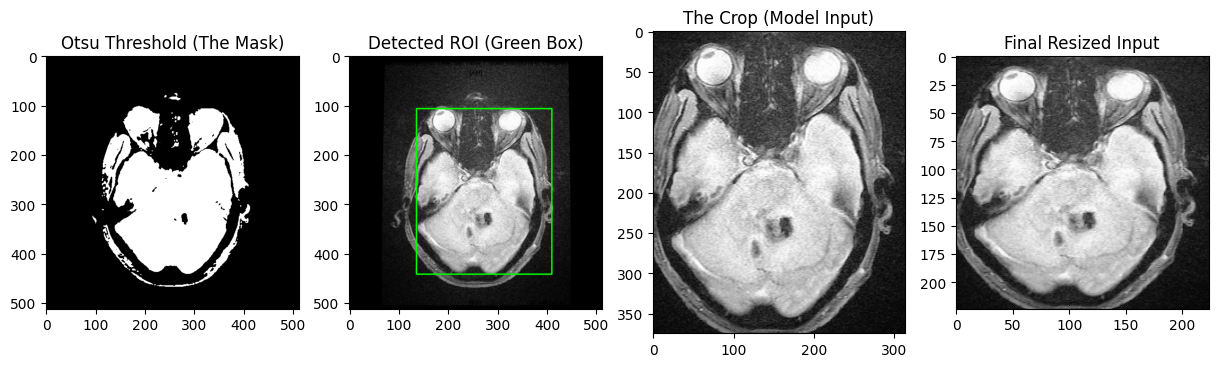

In [8]:
def debug_preprocessing(image_path):
    img = cv2.imread(image_path)
    if img is None: return

    # 1. Duplicate the logic from extract_roi_and_mask
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Visualization Canvas
    plt.figure(figsize=(15, 5))
    
    # Plot 1: The Threshold (What did it select?)
    ax1 = plt.subplot(1, 4, 1)
    ax1.imshow(thresh, cmap='gray')
    ax1.set_title("Otsu Threshold (The Mask)")
    
    if not contours:
        print("No contours found!")
        return

    # Find largest
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    
    # Plot 2: The Bounding Box on Original
    debug_img = img.copy()
    cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    ax2 = plt.subplot(1, 4, 2)
    ax2.imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
    ax2.set_title("Detected ROI (Green Box)")
    
    # Plot 3: The Resulting Crop
    pad = 20
    x_new = max(0, x - pad)
    y_new = max(0, y - pad)
    w_new = min(img.shape[1] - x_new, w + 2*pad)
    h_new = min(img.shape[0] - y_new, h + 2*pad)
    roi = img[y_new:y_new+h_new, x_new:x_new+w_new]
    
    ax3 = plt.subplot(1, 4, 3)
    ax3.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    ax3.set_title("The Crop (Model Input)")
    
    # Plot 4: Final Resize (What ResNet sees)
    final = cv2.resize(roi, (224, 224))
    ax4 = plt.subplot(1, 4, 4)
    ax4.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))
    ax4.set_title("Final Resized Input")
    
    plt.show()

# Run this on your problem image
debug_preprocessing("./Kuppusamy GRE-8.jpg_Haemorrhagic_29.png")

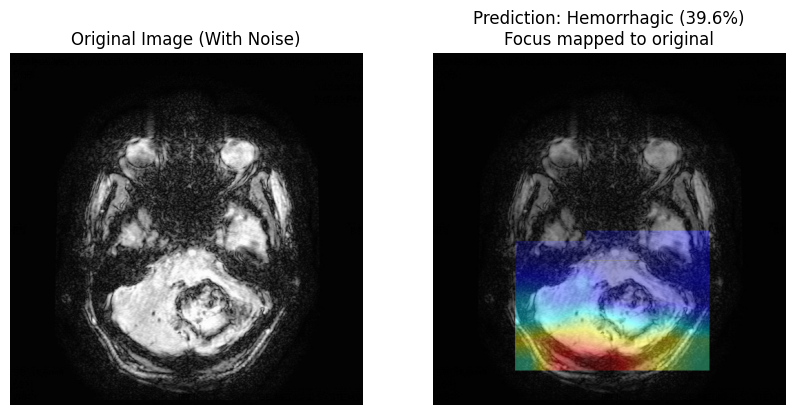

In [7]:
def predict_and_visualize_full(image_path, 
                               class_model_path="best_resnet_model_avg_94.56.pth", 
                               seg_model_path="unet_lesion_model_new.pth"):
    
    # 1. Load Original Image
    original_img = cv2.imread(image_path)
    if original_img is None: return
    original_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    # 2. Re-run Preprocessing to get Coordinates
    # We need to know WHERE the brain was cropped from
    gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours: 
        print("No brain found.")
        return
        
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    
    # Add Padding (Match the pipeline)
    pad = 20
    x_new = max(0, x - pad)
    y_new = max(0, y - pad)
    w_new = min(original_img.shape[1] - x_new, w + 2*pad)
    h_new = min(original_img.shape[0] - y_new, h + 2*pad)
    
    # Extract ROI for Model
    roi = original_img[y_new:y_new+h_new, x_new:x_new+w_new]
    
    # 3. Prepare for Model (CLAHE + Normalize + Resize)
    processed_roi = normalize_and_clahe(roi)
    processed_roi_resized = cv2.resize(processed_roi, (224, 224))
    processed_pil = Image.fromarray(cv2.cvtColor(processed_roi_resized, cv2.COLOR_BGR2RGB))
    
    # 4. Run Prediction & Grad-CAM
    class_model = get_model()
    class_model.load_state_dict(torch.load(class_model_path, map_location=DEVICE))
    class_model.eval()
    
    transform_tensor = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = transform_tensor(processed_pil).unsqueeze(0).to(DEVICE)
    
    # Predict
    with torch.no_grad():
        output = class_model(input_tensor)
        score, pred_idx = torch.max(torch.softmax(output, 1), 1)
    
    diagnosis = CLASSES[pred_idx.item()]
    conf = score.item() * 100
    
    # Grad-CAM
    grad_cam = GradCAM(class_model, class_model.layer4[-1])
    heatmap_small = grad_cam(input_tensor, pred_idx)
    
    # 5. INVERSE MAPPING (The Magic Step)
    # Resize 224x224 heatmap -> ROI size (w_new, h_new)
    heatmap_roi = cv2.resize(heatmap_small, (w_new, h_new))
    
    # Create a blank heatmap the size of the ORIGINAL image
    heatmap_full = np.zeros((original_img.shape[0], original_img.shape[1]), dtype=np.float32)
    
    # Place the ROI heatmap into the correct location
    heatmap_full[y_new:y_new+h_new, x_new:x_new+w_new] = heatmap_roi
    
    # Apply ColorMap
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_full), cv2.COLORMAP_JET)
    
    # Black out the background in the heatmap (optional, for cleanliness)
    heatmap_colored[heatmap_full == 0] = 0
    
    # Overlay on Original Image
    overlay = cv2.addWeighted(original_img, 0.6, heatmap_colored, 0.4, 0)
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    # 6. Display
    plt.figure(figsize=(10, 6))
    
    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(original_rgb)
    ax1.set_title("Original Image (With Noise)")
    ax1.axis('off')
    
    ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(overlay)
    ax2.set_title(f"Prediction: {diagnosis} ({conf:.1f}%)\nFocus mapped to original")
    ax2.axis('off')
    
    plt.show()

# Run it on your tricky image
predict_and_visualize_full("./Kuppusamy SWI-21.jpg_Haemorrhagic_16.png")